# Hệ khuyến nghị. IUH 2025.
### Ngày 11/9/2025. Lab 3.
Mục tiêu: lọc cộng tác, thao tác với item-based và user-based.

**Bài 1.** Lập trình tự động **lọc cộng tác**

Trong bày này, ta sẽ lập trình theo hướng Hướng Đối Tượng cho class CF. Class này được sử dụng chung cho cả User-user và Item-item CF. Trước hết, chúng ta sẽ thử nghiệm với ví dụ nhỏ trong bài, sau đó sẽ áp dụng vào bài toán với cơ sở dữ liệu MovieLens.

Trong bài này dùng file dữ liệu  mô tả dữ liệu đã biết cho ví dụ. Thứ tự của ba cột là user_id, item_id, và rating. Ví dụ, hàng đầu tiên nghĩa là u_0 rates i_0 số sao là 5.

Khi làm việc với Item-item CF, chúng ta chỉ cần đổi vị trí của hai cột đầu tiên để nhận được ma trận chuyển vị.

- 0 0 5.
- 0 1 4.
- 0 3 2.
- 0 4 2.
- 1 0 5.
- 1 2 4.
- 1 3 2.
- 1 4 0.
- 2 0 2.
- 2 2 1.
- 2 3 3.
- 2 4 4.
- 3 0 0.
- 3 1 0.
- 3 3 4.
- 4 0 1.
- 4 3 4.
- 5 1 2.
- 5 2 1.
- 6 2 1.
- 6 3 4.
- 6 4 5.

*SV đọc các comment, phân tích trong class CF bên dưới để hiểu rõ hơn các hàm trong đó.*

**Khởi tạo class CF**

Dữ liệu đầu vào của hàm khởi tạo class CF là ma trận Utility Y_data được lưu dưới dạng một ma trận với 3 cột, k là số lượng các điểm lân cận được sử dụng để dự đoán kết quả. dist_func là hàm đó **similarity giữa hai vectors**, mặc định là cosine_similarity được lấy từ sklearn.metrics.pairwise. Bạn đọc cũng có thể thử với các giá trị k và hàm dist_func khác nhau. Biến uuCF thể hiện việc đang sử dụng User-user CF (1) hay Item-item CF(0).

In [ ]:
import pandas as pd 
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 
class CF(object):
    """docstring for CF"""
    def __init__(self, Y_data, k, dist_func = cosine_similarity, uuCF = 1):
        self.uuCF = uuCF # user-user (1) or item-item (0) CF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]]
        self.k = k
        self.dist_func = dist_func
        self.Ybar_data = None
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1 
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1
    
    #Khi có dữ liệu mới, cập nhận Utility matrix bằng cách thêm các hàng này vào cuối Utility Matrix. 
    #Để cho đơn giản, giả sử rằng không có users hay items mới, cũng không có ratings nào bị thay đổi.
    
    def add(self, new_data):
        """
        Update Y_data matrix when new ratings come.
        For simplicity, suppose that there is no new user or item.
        """
        self.Y_data = np.concatenate((self.Y_data, new_data), axis = 0)
    
    #Tính toán normalized utility matrix và Similarity matrix
    
    def normalize_Y(self):
        users = self.Y_data[:, 0] # all users - first col of the Y_data
        self.Ybar_data = self.Y_data.copy()
        self.mu = np.zeros((self.n_users,))
        for n in range(self.n_users):
            # row indices of rating done by user n
            # since indices need to be integers, we need to convert
            ids = np.where(users == n)[0].astype(np.int32)
            # indices of all ratings associated with user n
            item_ids = self.Y_data[ids, 1] 
            # and the corresponding ratings 
            ratings = self.Y_data[ids, 2]
            # take mean
            m = np.mean(ratings) 
            if np.isnan(m):
                m = 0 # to avoid empty array and nan value
            self.mu[n] = m
            # normalize
            self.Ybar_data[ids, 2] = ratings - self.mu[n]

        ################################################
        # form the rating matrix as a sparse matrix. Sparsity is important 
        # for both memory and computing efficiency. For example, if #user = 1M, 
        # #item = 100k, then shape of the rating matrix would be (100k, 1M), 
        # you may not have enough memory to store this. Then, instead, we store 
        # nonzeros only, and, of course, their locations.
        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
            (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.tocsr()

    def similarity(self):
        eps = 1e-6
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)
    
    # Thực hiện lại 2 hàm phía trên khi có thêm dữ liệu.
        
    def refresh(self):
        """
        Normalize data and calculate similarity matrix again (after
        some few ratings added)
        """
        self.normalize_Y()
        self.similarity() 
        
    def fit(self):
        self.refresh()
        
    #Dự đoán kết quả: hàm __pred là hàm dự đoán rating mà user u cho item i cho trường hợp User-user CF. 
    #Vì trong trường hợp Item-item CF, chúng ta cần hiểu ngược lại nên hàm pred sẽ thực hiện đổi vị trí hai biến của __pred. 
    #Để cho API được đơn giản, tac có thể cho __pred là một phương thức private, chỉ được gọi trong class CF; 
    # pred là một phương thức public, thứ tự của biến đầu vào luôn là (user, item), bất kể phương pháp sử dụng là User-user CF hay Item-item CF.
    
    def __pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        # Step 1: find all users who rated i
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        # Step 2: 
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        # Step 3: find similarity btw the current user and others 
        # who already rated i
        sim = self.S[u, users_rated_i]
        # Step 4: find the k most similarity users
        a = np.argsort(sim)[-self.k:] 
        # and the corresponding similarity levels
        nearest_s = sim[a]
        # How did each of 'near' users rated item i
        r = self.Ybar[i, users_rated_i[a]]
        if normalized:
            # add a small number, for instance, 1e-8, to avoid dividing by 0
            return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)

        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]
    
    def pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        if self.uuCF: return self.__pred(u, i, normalized)
        return self.__pred(i, u, normalized)
            
    #Tìm tất cả các items nên được gợi ý cho user u trong trường hợp User-user CF, 
    # hoặc tìm tất cả các users có khả năng thích item u trong trường hợp Item-item CF
    
    def recommend(self, u):
        """
        Determine all items should be recommended for user u.
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which 
        have not been rated by u yet. 
        """
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist()              
        recommended_items = []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.__pred(u, i)
                if rating > 0: 
                    recommended_items.append(i)
        
        return recommended_items 

    # In toàn bộ kết quả:
        
    def recommend2(self, u):
        """
        Determine all items should be recommended for user u.
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which 
        have not been rated by u yet. 
        """
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist()              
        recommended_items = []
    
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.__pred(u, i)
                if rating > 0: 
                    recommended_items.append(i)
        
        return recommended_items 

    def print_recommendation(self):
        """
        print all items which should be recommended for each user 
        """
        print ('Recommendation: ')
        for u in range(self.n_users):
            recommended_items = self.recommend(u)
            if self.uuCF:
                print ('    Recommend item(s):', recommended_items, 'for user', u)
            else: 
                print ('    Recommend item', u, 'for user(s) : ', recommended_items)

Chúng ta sẽ thử với User-user CF trước:

In [ ]:
# data file 
r_cols = ['user_id', 'item_id', 'rating']
ratings = pd.read_csv('data.csv', sep = ',', names = r_cols, encoding='latin-1')
Y_data = ratings.values

rs = CF(Y_data, k = 5, uuCF = 1)
rs.fit()

rs.print_recommendation()

In [ ]:
Tiếp theo là với Item-item Collaborative Filtering:

In [ ]:
rs = CF(Y_data, k = 5, uuCF = 0)
rs.fit()

rs.print_recommendation()

Chúng ta cùng quay lại làm với cơ sở dữ liệu **MoiveLens 100k** như trong Content-based Recommendation Systems. Nhắc lại rằng kết quả của phương pháp này có trung bình lỗi là 1.2 sao với mỗi rating. Chúng ta cùng xem kết quả với User-user CF và Item-item CF.

Trước hết, ta cần load dữ liệu.

In [ ]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_base = pd.read_csv('ml-100k/ub.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('ml-100k/ub.test', sep='\t', names=r_cols, encoding='latin-1')

rate_train = ratings_base.values
rate_test = ratings_test.values

# indices start from 0
rate_train[:, :2] -= 1
rate_test[:, :2] -= 1

Kết quả với User-user CF:

In [ ]:
rs = CF(rate_train, k = 30, uuCF = 1)
rs.fit()

n_tests = rate_test.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs.pred(rate_test[n, 0], rate_test[n, 1], normalized = 0)
    SE += (pred - rate_test[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print ('User-user CF, RMSE =', RMSE)

Kết quả với Item-item CF:

In [ ]:
rs = CF(rate_train, k = 30, uuCF = 0)
rs.fit()

n_tests = rate_test.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs.pred(rate_test[n, 0], rate_test[n, 1], normalized = 0)
    SE += (pred - rate_test[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print ('Item-item CF, RMSE =', RMSE)

Từ đó ta nhận thấy Item-item CF cho lỗi nhỏ hơn (0.987) so với User-user CF (0.995) và tốt hơn so với Content-based Recommendation Systems ở bài trước. Các bạn cũng có thể thay **neighborhood size k** bằng các giá trị khác và so sánh kết quả._

**Collaborative Filtering** là một phương pháp gợi ý sản phẩm với ý tưởng chính dựa trên các hành vi của các users khác (collaborative) cùng trên một item để suy ra mức độ quan tâm (filtering) của một user lên sản phẩm. Việc suy ra này được thực hiện dựa trên Similarity matrix đo độ giống nhau giữa các users. 
Để tính được Similarity matrix, trước tiên ta cần chuẩn hoá dữ liệu. Phương pháp phổ biến là mean offset, tức trừ các ratings đi giá trị trung bình mà một user đưa ra cho các _items.

Similarity function thường được dụng là Cosine similarity hoặc Pearson correlat n.

User-user CF có một vài hạn chế khi lượng users là lớn. Trong các trường hợp đó, Item-item thường được sử dụng và cho kết quả tốt hơn.

**Bài 2.** Tìm hiểu các bước hoàn chỉnh để thực hiện lọc cộng tác để khuyến nghị theo cách khác

In [3]:
import pandas as pd

# Đọc dữ liệu đánh giá
ratings_df = pd.read_csv("ratings.csv")

# Giữ lại các cột cần thiết
ratings_df = ratings_df[["userId", "movieId", "rating"]]
movies_df = pd.read_csv("movies.csv")

# Kiểm tra cấu trúc
print(movies_df.head())
df = pd.merge(ratings_df, movies_df, on="movieId")

# Nếu chỉ cần userId, movieId, rating:
Y_data = df[["userId", "movieId", "rating"]].values


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [21]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

# Step 1: Load and filter data to avoid memory overload
ratings_df = pd.read_csv("ratings.csv")
movies_df = pd.read_csv("movies.csv")

# Chỉ giữ lại các phim phổ biến nhất (giảm số lượng item để tránh MemoryError)
top_items = ratings_df['movieId'].value_counts().head(1000).index
filtered_df = ratings_df[ratings_df['movieId'].isin(top_items)]

# Merge để lấy tiêu đề phim nếu cần
df = pd.merge(filtered_df, movies_df, on="movieId")

# Chuẩn bị dữ liệu cho CF
Y_data = df[["userId", "movieId", "rating"]].values

# Step 2: Define CF class
class CF:
    def __init__(self, Y_data, k=5, dist_func=cosine_similarity, uuCF=1):
        self.uuCF = uuCF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]]
        self.k = k
        self.dist_func = dist_func
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1

    def normalize_Y(self):
        users = self.Y_data[:, 0]
        self.Ybar_data = self.Y_data.copy()
        self.mu = np.zeros((self.n_users,))
        for n in range(self.n_users):
            ids = np.where(users == n)[0].astype(np.int32)
            ratings = self.Y_data[ids, 2]
            m = np.mean(ratings) if ratings.size > 0 else 0
            self.mu[n] = m
            self.Ybar_data[ids, 2] = ratings - m

        self.Ybar = sparse.coo_matrix(
            (self.Ybar_data[:, 2], (self.Ybar_data[:, 1], self.Ybar_data[:, 0])),
            shape=(self.n_items, self.n_users)
        ).tocsr()

    def similarity(self):
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)

    def refresh(self):
        self.normalize_Y()
        self.similarity()

    def fit(self):
        self.refresh()

    def __pred(self, u, i, normalized=1):
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        users_rated_i = self.Y_data[ids, 0].astype(np.int32)
        sim = self.S[u, users_rated_i]
        a = np.argsort(sim)[-self.k:]
        nearest_s = sim[a]
        r = self.Ybar[i, users_rated_i[a]]
        if normalized:
            return (r * nearest_s)[0] / (np.abs(nearest_s).sum() + 1e-8)
        return (r * nearest_s)[0] / (np.abs(nearest_s).sum() + 1e-8) + self.mu[u]

    def pred(self, u, i, normalized=1):
        return self.__pred(u, i, normalized) if self.uuCF else self.__pred(i, u, normalized)

    def recommend(self, u):
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist()
        recommended_items = []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.__pred(u, i)
                if rating > 0:
                    recommended_items.append(i)
        return recommended_items

    def print_recommendation(self):
        print("Recommendation:")
        for u in range(self.n_users):
            recommended_items = self.recommend(u)
            if self.uuCF:
                print(f"    Recommend item(s): {recommended_items} for user {u}")
            else:
                print(f"    Recommend item {u} for user(s): {recommended_items}")

# Step 3: Run the recommender system safely
rs = CF(Y_data, k=30, uuCF=1)  # uuCF=1 for user-user, uuCF=0 for item-item
rs.fit()
rs.print_recommendation()


Recommendation:
    Recommend item(s): [] for user 0


In [25]:
movie_data = movie_data.loc[:1000000, :]
movie_data.shape

(100836, 5)

In [27]:
user_item_matrix = movie_data.pivot(index='movieId',columns='userId',values='rating').fillna(0)
user_item_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


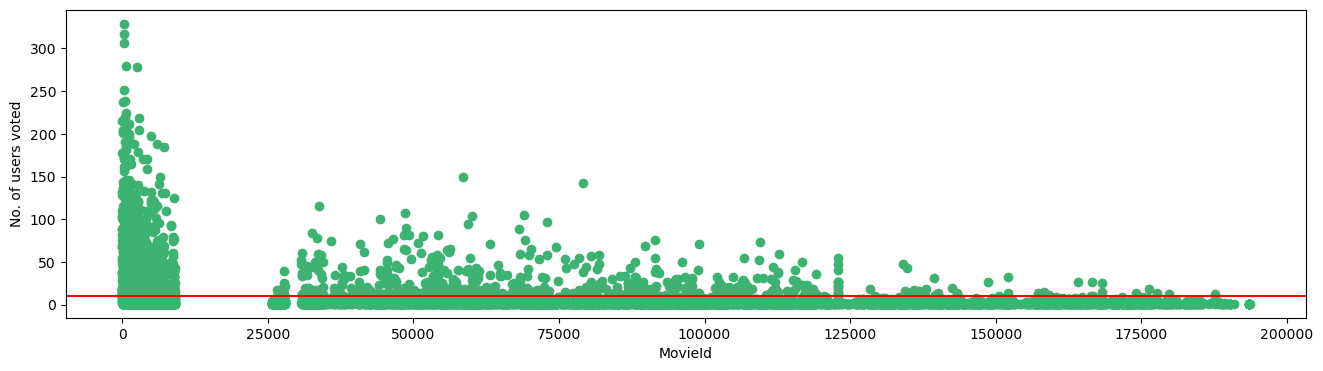

In [31]:
import matplotlib.pyplot as plt
#Removing noise from the data
no_user_voted = movie_data.groupby('movieId')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [35]:
user_item_matrix = user_item_matrix.loc[no_user_voted[no_user_voted >= 10].index,:]
user_item_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


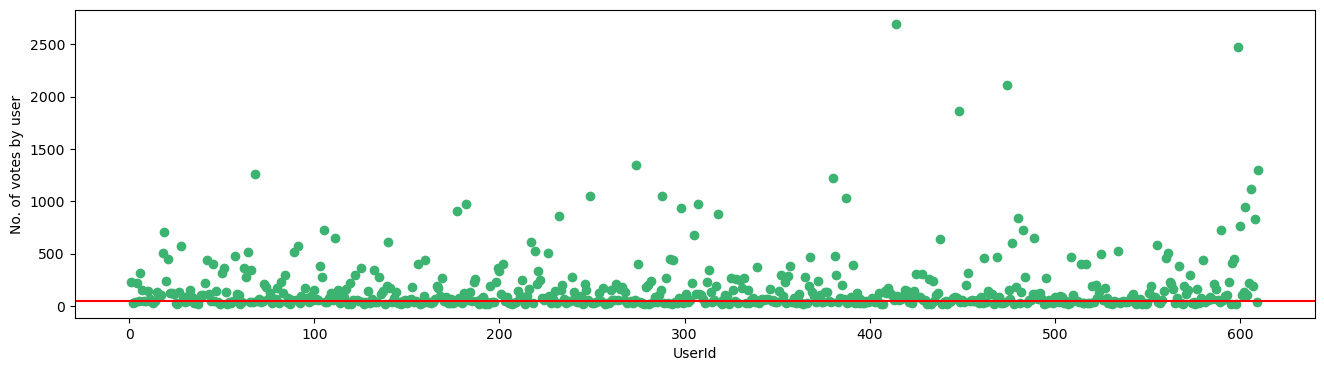

In [37]:
no_movies_voted = movie_data.groupby('userId')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [39]:
user_item_matrix = user_item_matrix.loc[: ,no_movies_voted[no_movies_voted >= 50].index]
user_item_matrix

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
#Removing the sparsity
from scipy.sparse import csr_matrix

csr_data = csr_matrix(user_item_matrix.values)
user_item_matrix.reset_index(inplace=True)

In [43]:
#Building the KNN Model
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [45]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies_df[movies_df['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = user_item_matrix[user_item_matrix['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = user_item_matrix.iloc[val[0]]['movieId']
            idx = movies_df[movies_df['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies_df.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [49]:
#Getting the recommendations, you can try another movie name
get_movie_recommendation("Toy Story")

,Title,Distance
1,Raiders of the Lost Ark (Indiana Jones and the...,0.401436
2,Pulp Fiction (1994),0.400937
3,Groundhog Day (1993),0.400499
4,Apollo 13 (1995),0.392429
5,Star Wars: Episode VI - Return of the Jedi (1983),0.391007
6,Shrek (2001),0.386068
7,Star Wars: Episode IV - A New Hope (1977),0.383767
8,Toy Story 2 (1999),0.376306
9,Forrest Gump (1994),0.360573
10,Jurassic Park (1993),0.341299


**Bài 3.** Thực hiện step-by-step theo các hướng dẫn sau, SV có thể dùng lại bộ dữ liệu ở trên, tự load lại các biến với tên thích hợp. Tham khảo thêm tại: https://campus.datacamp.com/courses/building-recommendation-engines-in-python/collaborative-filtering?ex=1

**Pivoting your data**
Trong chương này, bạn sẽ tiến một bước xa hơn trong việc tạo ra các đề xuất được cá nhân hóa — bạn sẽ tìm thấy các mục mà những người dùng tương tự như người bạn đang đề xuất thích. Bước đầu tiên bạn cần bắt đầu là định dạng dữ liệu của mình. Bạn bắt đầu với một tập dữ liệu chứa người dùng và xếp hạng của họ dưới dạng các hàng riêng lẻ với các cột sau:

user: ID người dùng

title: Tựa đề phim

rating: Xếp hạng mà người dùng đã đưa ra cho bộ phim

Bạn sẽ cần chuyển đổi DataFrame thành ma trận xếp hạng người dùng, trong đó mỗi hàng đại diện cho một người dùng và mỗi cột đại diện cho các bộ phim trên nền tảng. Điều này sẽ cho phép bạn dễ dàng so sánh người dùng và sở thích của họ.

In [1]:


import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsRegressor

# Tải dữ liệu
ratings = pd.read_csv("movie_lens/ratings.csv")
movies = pd.read_csv("movie_lens/movies.csv")

# Gộp hai bảng và chỉ giữ lại các cột cần thiết
user_ratings = pd.merge(ratings, movies, on="movieId")
user_ratings = user_ratings[['userId', 'title', 'rating']]

# Tạo một tập dữ liệu con để xử lý nhanh hơn
user_ratings_subset = user_ratings.head(10000)

In [2]:
# Inspect the first 5 rows of user_ratings
# Inspect the first 5 rows of user_ratings
print(user_ratings.head())

# Pivot the data
user_ratings_table = user_ratings_subset.pivot_table(index='userId', columns='title', values='rating')

# Inspect the first 5 rows of the pivoted table
print(user_ratings_table.head())

   userId                        title  rating
0       1             Toy Story (1995)     4.0
1       1      Grumpier Old Men (1995)     4.0
2       1                  Heat (1995)     4.0
3       1  Seven (a.k.a. Se7en) (1995)     5.0
4       1   Usual Suspects, The (1995)     5.0
title   'Tis the Season for Love (2015)  'burbs, The (1989)  \
userId                                                        
1                                   NaN                 NaN   
2                                   NaN                 NaN   
3                                   NaN                 NaN   
4                                   NaN                 NaN   
5                                   NaN                 NaN   

title   (500) Days of Summer (2009)  \
userId                                
1                               NaN   
2                               NaN   
3                               NaN   
4                               NaN   
5                               NaN   

ti

**Finding similar users**

Lọc cộng tác được xây dựng dựa trên tiền đề rằng những người dùng đã xếp hạng các mục tương tự trong quá khứ có sở thích tương tự, và do đó có khả năng xếp hạng các mục mới theo cách tương tự
A subset of the movies dataset has been loaded as user_ratings_subset. The DataFrame contains user ratings with a row for each user and a column for each movie.

**Challenges with missing values**
Bạn có thể đã nhận thấy rằng các DataFrame đã được xoay trục mà bạn đang làm việc thường có dữ liệu bị thiếu. Điều này là bình thường vì người dùng hiếm khi xem tất cả các bộ phim, và hầu hết các bộ phim không được mọi người xem, dẫn đến các khoảng trống trong ma trận người dùng-xếp hạng.ty.

**Compensating for incomplete data**
Đối với hầu hết các tập dữ liệu, phần lớn người dùng sẽ chỉ xếp hạng một số lượng nhỏ các mục. Như bạn đã thấy trong bài tập trước, cách bạn xử lý những người dùng không có xếp hạng cho một mục có thể ảnh hưởng lớn đến tính hợp lệ của mô hình.

Trong bài tập này, bạn sẽ điền vào dữ liệu bị thiếu bằng thông tin không làm sai lệch dữ liệu bạn có. Bạn sẽ lấy điểm trung bình mà mỗi người dùng đã đưa ra cho tất cả các xếp hạng của họ, sau đó sử dụng giá trị trung bình này để hiệu chỉnh điểm số của người dùng xoay quanh giá trị 0. Cuối cùng, bạn sẽ có thể điền vào các giá trị trống bằng số 0, lúc này là một điểm trung tính, giảm thiểu tác động lên hồ sơ tổng thể của họ nhưng vẫn cho phép so sánh người dùng.

In [3]:
# Get the average rating for each user 
avg_ratings = user_ratings_table.mean(axis=1)

# Center each users ratings around 0
user_ratings_table_centered = user_ratings_table.sub(avg_ratings, axis=0)

# Fill in the missing data with 0s
user_ratings_table_normed = user_ratings_table_centered.fillna(0)

# In ra 5 dòng đầu tiên của bảng đã chuẩn hóa
print(user_ratings_table_normed.head())

title   'Tis the Season for Love (2015)  'burbs, The (1989)  \
userId                                                        
1                                   0.0                 0.0   
2                                   0.0                 0.0   
3                                   0.0                 0.0   
4                                   0.0                 0.0   
5                                   0.0                 0.0   

title   (500) Days of Summer (2009)  \
userId                                
1                               0.0   
2                               0.0   
3                               0.0   
4                               0.0   
5                               0.0   

title   00 Schneider - Jagd auf Nihil Baxter (1994)  1-900 (06) (1994)  \
userId                                                                   
1                                               0.0                0.0   
2                                               0.0           

**User-based to item-based**

Bây giờ bạn đã có một tập dữ liệu không có giá trị trống và sẵn sàng để sử dụng.

Trong video trước, bạn đã tìm hiểu về cả đề xuất dựa trên người dùng và đề xuất dựa trên vật phẩm. Đề xuất dựa trên người dùng so sánh giữa các người dùng, và đề xuất dựa trên vật phẩm so sánh các vật phẩm khác nhau.

Nói cách khác, bạn có thể sử dụng dữ liệu dựa trên người dùng để tìm những người dùng tương tự dựa trên cách họ xếp hạng các bộ phim khác nhau, trong khi bạn có thể sử dụng dữ liệu dựa trên vật phẩm để tìm các bộ phim tương tự dựa trên cách chúng được xếp hạng bởi người dùng

**Similar and different movie ratings**
    
Một số loại phim có thể được một nhóm người yêu thích, nhưng lại bị một nhóm khác ghét. Điều này có thể phản ánh loại phim nhiều hơn là chất lượng của nó. Ví dụ, phim kinh dị — nhiều người hoàn toàn yêu thích chúng, trong khi những người khác lại ghét chúng.

Bằng cách hiểu những bộ phim nào được đánh giá theo cách tương tự, chúng ta thường có thể tìm thấy những bộ phim rất giống nhau.

In [4]:
# Transpose the user_ratings_table_normed
movie_ratings_centered = user_ratings_table_normed.T
print(movie_ratings_centered.head())

userId                                        1    2    3    4    5    6   \
title                                                                       
'Tis the Season for Love (2015)              0.0  0.0  0.0  0.0  0.0  0.0   
'burbs, The (1989)                           0.0  0.0  0.0  0.0  0.0  0.0   
(500) Days of Summer (2009)                  0.0  0.0  0.0  0.0  0.0  0.0   
00 Schneider - Jagd auf Nihil Baxter (1994)  0.0  0.0  0.0  0.0  0.0  0.0   
1-900 (06) (1994)                            0.0  0.0  0.0  0.0  0.0  0.0   

userId                                        7    8    9    10  ...   57  \
title                                                            ...        
'Tis the Season for Love (2015)              0.0  0.0  0.0  0.0  ...  0.0   
'burbs, The (1989)                           0.0  0.0  0.0  0.0  ...  0.0   
(500) Days of Summer (2009)                  0.0  0.0  0.0  0.0  ...  0.0   
00 Schneider - Jagd auf Nihil Baxter (1994)  0.0  0.0  0.0  0.0  ...  0.0  

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

# Gán các mảng vào biến (đảm bảo rằng các phim này có trong tập dữ liệu con)
# Lưu ý: Các phim Star Wars có thể không có trong user_ratings_subset.
# Chúng ta sẽ thay thế bằng các phim phổ biến hơn có trong dữ liệu.
movie1_title = 'Forrest Gump (1994)'
movie2_title = 'Pulp Fiction (1994)'

movie1 = movie_ratings_centered.loc[movie1_title, :].values.reshape(1, -1)
movie2 = movie_ratings_centered.loc[movie2_title, :].values.reshape(1, -1)

# Tìm độ tương đồng giữa hai bộ phim
similarity = cosine_similarity(movie1, movie2)
print(similarity)

[[0.08278467]]


**Finding similarly liked movies**

Giống như cách bạn đã tính toán độ tương tự giữa hai bộ phim, bạn có thể tính toán nó trên tất cả người dùng để tìm ra bộ phim tương tự nhất với một bộ phim khác dựa trên cách người dùng đã xếp hạng chúng.

Cách tiếp cận tương tự như cách bạn đã làm với lọc dựa trên nội dung. Bạn sẽ tìm điểm tương tự giữa tất cả các bộ phim và sau đó tập trung vào bộ phim quan tâm bằng cách cô lập và sắp xếp cột chứa điểm tương tự của nó.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

# Tạo ma trận tương đồng
similarities = cosine_similarity(movie_ratings_centered)

# Bọc ma trận tương đồng trong một DataFrame
cosine_similarity_df = pd.DataFrame(similarities, index=movie_ratings_centered.index, columns=movie_ratings_centered.index)

# Tìm các giá trị tương đồng cho một bộ phim cụ thể
cosine_similarity_series = cosine_similarity_df.loc['Toy Story (1995)']

# Sắp xếp các giá trị này từ cao nhất đến thấp nhất
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

print(ordered_similarities.head())

title
Toy Story (1995)              1.000000
Omega Man, The (1971)         0.542379
Shakespeare in Love (1998)    0.529266
Blues Brothers, The (1980)    0.526704
This Is Spinal Tap (1984)     0.523068
Name: Toy Story (1995), dtype: float64


**Stepping through K-nearest neighbors**

You have just seen how K-nearest neighbors can be used to infer how someone might rate an item based on the wisdom of a (similar) crowd. In this exercise, you will step through this process yourself to ensure a good understanding of how it works. To get you started, as you have generated similarity matrices many times before, that step has been done for you with the user similarity matrix wrapped in a DataFrame loaded as *user_similarities*.

This has each user as the rows and columns, and where they meet the corresponding similarity score.

In this exercise, you will be working with *user_001*'s similarity scores, find their nearest neighbors, and based on the ratings those neighbors gave a movie, infer what rating user_001 might give it if they saw it.

In [9]:
# Tạo ma trận tương đồng người dùng
user_similarities_matrix = cosine_similarity(user_ratings_table_normed)
user_similarities = pd.DataFrame(user_similarities_matrix, index=user_ratings_table_normed.index, columns=user_ratings_table_normed.index)

# Tách điểm tương đồng cho user 1 và sắp xếp
user_similarity_series = user_similarities.loc[1]
ordered_similarities = user_similarity_series.sort_values(ascending=False)

# Tìm 10 người dùng giống nhất (bỏ qua người dùng đầu tiên vì đó là chính họ)
nearest_neighbors = ordered_similarities[1:11].index

# Trích xuất xếp hạng của những người hàng xóm này
neighbor_ratings = user_ratings_table.loc[nearest_neighbors]

# Tính xếp hạng trung bình mà những người hàng xóm gần nhất đã đưa ra
# Lưu ý: 'Apollo 13 (1995)' có thể không có trong dữ liệu con, thay bằng 'Forrest Gump (1994)'
print(neighbor_ratings['Forrest Gump (1994)'].mean())

3.5833333333333335


In [ ]:
# Isolate the similarity scores for user_1 and sort
# Lưu ý: Trong notebook, userId là số nguyên, nên ta sẽ dùng user_id = 1 thay vì 'user_001'
user_similarity_series = user_similarities.loc[1]
ordered_similarities = user_similarity_series.sort_values(ascending=False)

# Find the top 10 most similar users
# .index sẽ lấy ra ID của những người dùng tương tự nhất
nearest_neighbors = ordered_similarities[1:11].index

# Extract the ratings of the neighbors
# .loc được dùng để trích xuất các hàng dựa trên index (userId)
neighbor_ratings = user_ratings_table.loc[nearest_neighbors]

# Calculate the mean rating given by the users nearest neighbors
# .mean() để tính giá trị trung bình
print(neighbor_ratings['Apollo 13 (1995)'].mean())

**Getting KNN data in shape**
Bây giờ bạn đã hiểu rõ các chi tiết về cách K-hàng xóm gần nhất hoạt động, bạn có thể tận dụng việc triển khai KNN của scikit-learn trong khi nhận ra những gì nó đang làm bên dưới.

Trong hai bài tập tiếp theo, bạn sẽ thực hiện cách chuẩn bị dữ liệu cho mô hình KNN của scikit-learn, và sau đó sử dụng nó để đưa ra suy luận về xếp hạng mà một người dùng có thể đưa ra cho một bộ phim họ chưa xem

In [10]:
# Sử dụng bảng đã chuẩn hóa (centered và fill 0)
users_to_ratings = user_ratings_table_normed
target_movie = "Apollo 13 (1995)"
target_user_id = 1

# Bỏ cột bạn đang cố gắng dự đoán
users_to_ratings_dropped = users_to_ratings.drop(target_movie, axis=1, inplace=False)

# Lấy dữ liệu cho người dùng bạn đang dự đoán
target_user_x = users_to_ratings_dropped.loc[[target_user_id]]

# Dữ liệu cho các người dùng khác
other_users_x = users_to_ratings_dropped.drop(target_user_id)
other_users_y = user_ratings_table[target_movie].drop(target_user_id).fillna(0) # Dùng rating gốc

**KNN predictions**
With the data in the correct shape from the last exercise, you can now use it to infer how user_001 feels about Apollo 13 (1995)

As a reminder, the data you prepared in the last exercise (and have been loaded into this one) are:
- target_user_x - Centered ratings that user_001 has given to the movies they have seen.
- other_users_x - Centered ratings for all other users and the movies they have rated excluding the movie Apollo 13.
- other_users_y - Raw ratings that all other users have given the movie Apollo 13.
  
You will use other_users_x and other_users_y to fit a KNeighborsRegressor from scikit-learn and use it to predict what user_001 might have rated Apollo 13 (1995).

In [11]:
# Import the regressor
from sklearn.neighbors import KNeighborsRegressor

# Khởi tạo mô hình KNN
user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=10)

# Fit mô hình và dự đoán cho người dùng mục tiêu
user_knn.fit(other_users_x, other_users_y)
user_pred = user_knn.predict(target_user_x)

print(f"Dự đoán rating của user {target_user_id} cho phim {target_movie}: {user_pred[0]}")

Dự đoán rating của user 1 cho phim Apollo 13 (1995): 1.5


**Comparing item-based and user-based models**

Với dữ liệu đã được định dạng đúng từ bài tập trước, bạn có thể sử dụng nó để suy ra cảm nhận của user_001 về bộ phim Apollo 13 (1995).

Comparing item-based and user-based models

Tiếng Việt: So sánh các mô hình dựa trên vật phẩm và dựa trên người dùng

Bây giờ bạn đã xem xét hai cách tiếp cận KNN khác nhau. Cách thứ nhất là item-item KNN, nơi bạn sử dụng trung bình của các bộ phim tương tự nhất mà một người dùng đã xếp hạng để đề xuất một xếp hạng cho một bộ phim họ chưa xem. Cách tiếp cận khác là user-user KNN, nơi bạn sử dụng trung bình của các xếp hạng mà những người dùng tương tự nhất đã đưa ra cho bộ phim để đề xuất xếp hạng mà người dùng mục tiêu sẽ đưa ra cho bộ phim đó.

In [12]:
# Dữ liệu cho mô hình user-user (đã chuẩn bị ở trên)
# Mục tiêu: Dự đoán rating của user 2 cho phim Forrest Gump (1994)
target_user_id = 2
target_movie = 'Forrest Gump (1994)'

# Chuẩn bị dữ liệu
user_x = user_ratings_table_normed.drop(target_movie, axis=1)
target_user_x = user_x.loc[[target_user_id]]
other_users_x = user_x.drop(target_user_id)
other_users_y = user_ratings_table[target_movie].drop(target_user_id).fillna(0)

# Khởi tạo mô hình user-KNN
user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=10)

# Fit mô hình và dự đoán
user_knn.fit(other_users_x, other_users_y)
user_user_pred = user_knn.predict(target_user_x)
print("The user-user model predicts {}".format(user_user_pred[0]))

# --- Dữ liệu cho mô hình item-item ---
# Chuyển vị ma trận
item_ratings_normed = user_ratings_table_normed.T

# Chuẩn bị dữ liệu
item_x = item_ratings_normed.drop(target_user_id, axis=1)
target_movie_x = item_x.loc[[target_movie]]
other_movies_x = item_x.drop(target_movie)
other_movies_y = item_ratings_normed[target_user_id].drop(target_movie).fillna(0)

# Khởi tạo mô hình item-KNN
movie_knn = KNeighborsRegressor(metric='cosine', n_neighbors=10)

# Fit mô hình và dự đoán
movie_knn.fit(other_movies_x, other_movies_y)
item_item_pred = movie_knn.predict(target_movie_x)
print("The item-item model predicts {}".format(item_item_pred[0]))

The user-user model predicts 3.25
The item-item model predicts -0.13965517241379305
